# Previsão de valor do Biticoin
### Proposta do projeto

Com a alta das criptomoedas, ter o auxilio de uma machine learning para ajudar nas decisões do dia a dia é uma ótima opção. Pensando nisso, nós criamos o modelo abaixo para efetuar a previsão do valor do bitcoin.

### Etapa 1: Coleta de dados

Para efetuar a previsão, o primeiro passo é alimentar o nosso sistema com dados, para isto iremos utilizar a api `CoinGecko` que nos fornece dados da abertura e fechamento do valor diário do Biticoin. Iremos tambem utilizar as seguintes bibliotecas do python 
- `requests` -> para efetuar as requisições na api;
- `pandas` -> utilizado para organização e manipulação dos dados;
- `matplotlib.pyplot` -> para efetuar a exibição de gráficos;


              mean_price   final_price
timestamp                             
2023-12-06  44105.944773  44105.944773
2023-12-07  43788.288808  43788.288808
2023-12-08  43270.119560  43270.119560
2023-12-09  44202.176109  44202.176109
2023-12-10  43745.491992  43745.491992


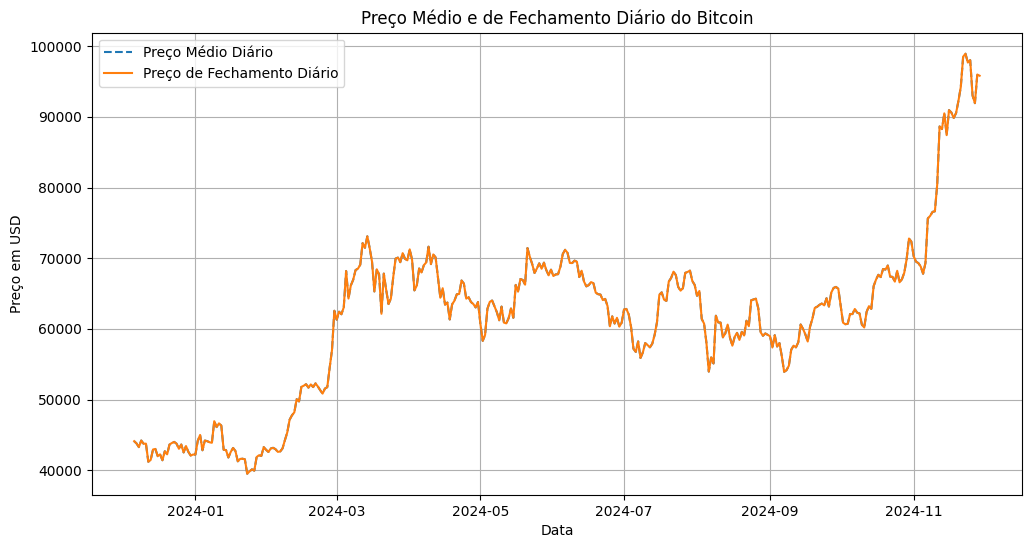

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

def fetch_bitcoin_data(days=90):
    # Configurações da API da CoinGecko
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
    params = {
        'vs_currency': 'usd',
        'days': str(days)
    }

    # Fazer requisição para a API
    response = requests.get(url, params=params)
    data = response.json()

    # Verificar se os dados foram retornados corretamente
    if 'prices' in data:
        # Criar DataFrame com os preços
        df = pd.DataFrame(data['prices'], columns=['timestamp', 'close'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)

        # Reordenar colunas
        df = df[['close']]
        return df
    else:
        print("Erro ao obter dados:", data)
        return None

# Coletar dados
df = fetch_bitcoin_data(360)

# Agregar dados para obter o preço médio e final diário
df_daily = df.resample('D').agg({'close': ['mean', 'last']})
df_daily.columns = ['mean_price', 'final_price']  # Renomear colunas

# Exibir os primeiros dados agregados
print(df_daily.head())

# Plotar o gráfico
plt.figure(figsize=(12, 6))
plt.plot(df_daily.index, df_daily['mean_price'], label='Preço Médio Diário', linestyle='--')
plt.plot(df_daily.index, df_daily['final_price'], label='Preço de Fechamento Diário', linestyle='-')
plt.xlabel('Data')
plt.ylabel('Preço em USD')
plt.title('Preço Médio e de Fechamento Diário do Bitcoin')
plt.legend()
plt.grid(True)
plt.show()


### Normalização de Dados e Preparação para LSTM

Antes de alimentar nosso modelo LSTM (Long Short-Term Memory), precisamos normalizar os dados e organizá-los no formato adequado.


#### Importação das Bibliotecas Necessárias

Utilizamos a classe `MinMaxScaler` da biblioteca `sklearn` para normalizar os valores de fechamento do Bitcoin no intervalo entre 0 e 1.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

#### Normalização dos Dados de Fechamento
Utilizamos o `MinMaxScaler` para normalizar os preços de fechamento entre 0 e 1. A normalização é uma etapa crucial para melhorar o desempenho dos algoritmos de aprendizado de máquina, especialmente em redes neurais.

In [ ]:
# Normalizar dados de fechamento
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['close'].values.reshape(-1, 1))

- `MinMaxScaler` -> Transforma os dados para que fiquem dentro de um intervalo específico (neste caso, entre 0 e 1).
- `reshape(-1, 1)` -> Ajusta os dados para a forma necessária pela função fit_transform.

#### Criação do Conjunto de Dados para o LSTM
Definimos uma função para criar conjuntos de dados de entrada (`X`) e saída (`Y`) para o modelo. Usaremos uma janela deslizante de 60 dias anteriores para prever o preço do próximo dia.

In [ ]:

# Preparar dados para LSTM com intervalo diário
def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])  # 60 dias anteriores
        Y.append(dataset[i + look_back, 0])      # Preço do dia seguinte
    return np.array(X), np.array(Y)

- Parâmetros:
  - `dataset`: O conjunto de dados normalizado.
  - `look_back`: Número de dias anteriores usados para prever o próximo valor (padrão é 60).
- Retorna:
  - `X`: Sequências de 60 dias de preços normalizados.
  - `Y`: Preços normalizados correspondentes ao dia seguinte.

In [ ]:
look_back = 60  # Usar 60 dias anteriores para prever o próximo
X, Y = create_dataset(scaled_data, look_back)

#### Reshape dos Dados para o Formato do LSTM
O modelo LSTM espera os dados de entrada no formato de três dimensões: `[samples, time_steps, features]`. Ajustamos `X` para atender a esse formato.

In [ ]:
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Formato adequado para LSTM

### Etapa 3: Criação do Dataset para LSTM
A função `create_dataset` é responsável por criar conjuntos de dados no formato necessário para o modelo LSTM. Usamos um intervalo de 60 dias anteriores (`look_back`) para prever o preço do dia seguinte.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Construir o modelo LSTM
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
model.fit(X, Y, epochs=100, batch_size=16)


Epoch 1/100


c:\Users\diogoantonio\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0609
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0106
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0073
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0047
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0051
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0051
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0052
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0046
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0035
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0037
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0045
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0037
Epoch 13/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0037
Epoch 14/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0043
Epoch 15/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0044
E

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0015 - val_loss: 0.0050
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0014 - val_loss: 0.0055
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0016 - val_loss: 0.0042
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0014 - val_loss: 0.0034
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0015 - val_loss: 0.0046
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0012 - val_loss: 0.0030
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0014 - val_loss: 0.0030
E

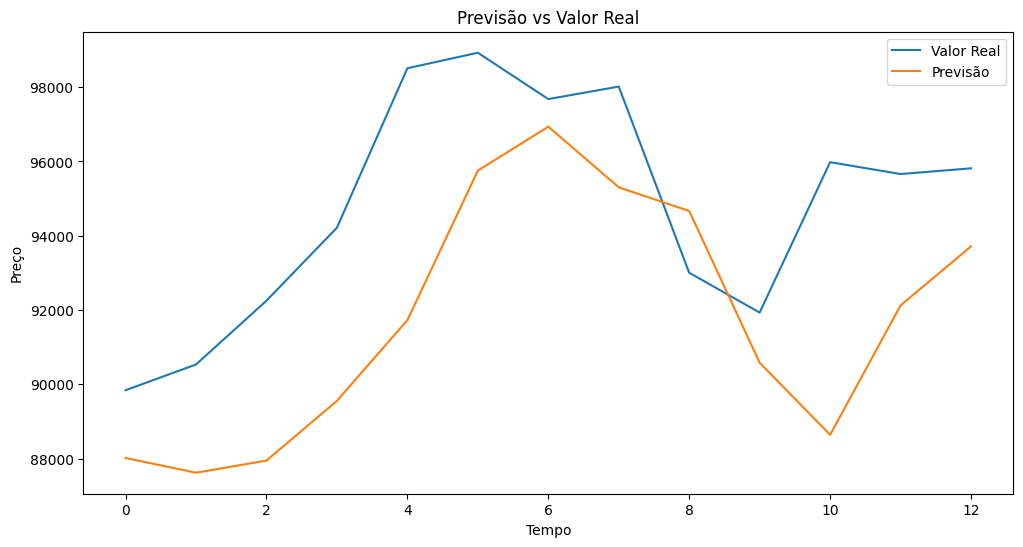

In [4]:
# Dividir os dados em treinamento e teste
train_size = int(len(scaled_data) * 0.8)
train, test = scaled_data[0:train_size], scaled_data[train_size:]

# Preparar dados para treino e teste
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# Ajustar dimensões para LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Treinar o modelo
model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test))

# Fazer previsões e reverter a normalização
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
Y_test = scaler.inverse_transform([Y_test])

# Calcular RMSE e MAE
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = math.sqrt(mean_squared_error(Y_test[0], predictions[:, 0]))
mae = mean_absolute_error(Y_test[0], predictions[:, 0])
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

# Gráfico de comparação
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(Y_test[0], label='Valor Real')
plt.plot(predictions[:, 0], label='Previsão')
plt.xlabel('Tempo')
plt.ylabel('Preço')
plt.title('Previsão vs Valor Real')
plt.legend()
plt.show()
